# Xylo™-A3 `AFESim` Quick Start Tutorial

Xylo™-A3 HDK contains a signal pre-processing module which is designed to encode an audio signal in the form of spike trains.
This module is named as **A**udio **F**ront-**E**nd, and it efficiently:

* captures audio from a microphone, 
* converts analog signals into digital waveforms, 
* performs band-pass filtering to isolate specific frequency ranges, 
* encodes signals into spike trains, 
* and ultimately delivers these spike trains to the Spiking Neural Network (SNN) core.

Here in this tutorial, we will introduce `AFESim`, the simulated counterpart of actual `AFE` module. This tutorial covers the usage and functionalities of `AFESim` in a beginner friendly manner.


## Getting Started

Let's first investigate the block diagram of the input pre-processing pipeline

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from IPython.display import Image

Image("figures/av3_block.png")

We see that there are two different microphones capturing the audio signals from air.
One of them is a **digital PDM microphone**, and the other is an **analog microphone**.
The red path, which is the one with an analog microphone, has some extra modules for automatic gain control and analog to digital conversion.
The blue path, which is the one with a digital microphone, does not need an ADC but it employs a polyphase low pass filter to reduce the speed of the signal and to obtain a 14-bit integer signal.

The [AFESim with Analog Microphone](afesim_agc.html) tutorial covers the details of the analog path.
The [AFESim with PDM Microphone](afesim_pdm.html) tutorial covers the details of the digital path.

One can choose to use one of these paths in the hardware. In simulation, it's also possible that one skips the microphone paths and directly feeds the signal to the filter.

Therefore, `AFESim` has 3 different modes of operation:

* **"analog"** : simulates a scenario that one uses analog microphone to catch the audio signals. Namely the module `AFESimAGC` simulates analog microphone's process of converting analog signals into digital waveforms, then utilizes the rest of the pipeline.
* **"pdm"** : simulates a scenario that one uses PDM microphone to catch the audio signals. The module called `AFESimPDM` processes a audio recording to make it look like it's generated by the PDM microphone, then utilizes the rest of the pipeline.
* **"external"** : `AFESimExternal` skips the microphone paths, resamples the signal to meet the filter requirements, then utilizes the rest of the pipeline.

In this tutorial, we will focus on common part of the pipeline. We'll by-pass the microphone paths, and provide an externally generated signal to the rest of the pipeline. This mode is considered as the "external" mode of AFESim, `AFESimExternal`. It's especially useful for debugging purposes, and not intended to be used in the actual hardware. The figure below shows the block diagram of the pipeline that we will be using in this tutorial.

In [3]:
Image("figures/afesim_external.png")

* **Resampling & Quantization** : Resamples the input signal to 48.8 kHz, and quantizes it to 14-bit integers.
This step is necessary to make any input signal compatible with the real input sources, which are the analog and the PDM microphones.
`AFESimExternal` handles this step automatically, so the user does not need to worry about it.

* **Filter Bank** : A set of 16 band-pass filters, optimized to cover the frequency range of the human voice. 
Since the output of each filter is a 14-bit integer signal, the output of the filter bank is a 16-channel 14-bit integer signal.

* **Divisive Normalization or IAF spike generation** : Comes after the filter bank.
Divisive normalization provides a way to set dynamic, **adaptive thresholds** for spike generation depending on the instantaneous power of the signal.
The alternative path to the divisive normalization is the IAF spike generation block.
The IAF spike generation block generates spikes with a fixed threshold.
The output of the divisive normalization or the IAF spike generation block is 16-channel 1-bit spike trains.

* **Rastering** : Accumulates the spikes in a 16-channel 4-bit rasters with a configurable time window.
The rasters are the final output of the AFE block, and they are sent to the SNN core.

In [4]:
import json

import librosa
from doc_utils import (
    generate_chirp,
    plot_chirp_signal,
    plot_divisive_normalization_output,
    plot_filter_bank_output,
    plot_raster_output,
)

from rockpool.devices.xylo.syns65302 import AFESimExternal

from samna.xyloA3.configuration import InputInterfaceConfig


## Load an audio file

To start with, we need to load an audio file. The audio file we'll use here is a chirp signal whose frequency increases linearly from 20 Hz to 20 kHz in 4 seconds. We do not need to worry too much about the sampling rate because `AFESimExternal` will resample the signal to 48.8 kHz automatically. Still, we need to make sure that the signal is in the range of [-1, 1] to prevent clipping. Also, we need to make sure that the signal meets the Nyquist criteria, which means that the highest frequency in the signal should be less than half of the sampling rate.

Let's load the audio file and plot the waveform. For the sake of visualisation, we will only use the first 0.1 second of the audio file.

NOTE : You can generate your chirp signal using `doc_utils.generate_chirp()` function, or you can use any other audio file you want. Just make sure you provide real or dummy `start_freq` and `end_freq` values if you're planning to use the plotting utils provided here.

In [5]:
# generate_chirp(filename="freq_sweep.wav", start_freq=20, end_freq=20_000, duration=4.0)

In [6]:
filename = "freq_sweep.wav"

signal, sr = librosa.load(filename, sr=None)
audio_specs = json.load(open("freq_sweep.json", "r"))
start_freq = audio_specs["start_freq"]
end_freq = audio_specs["end_freq"]

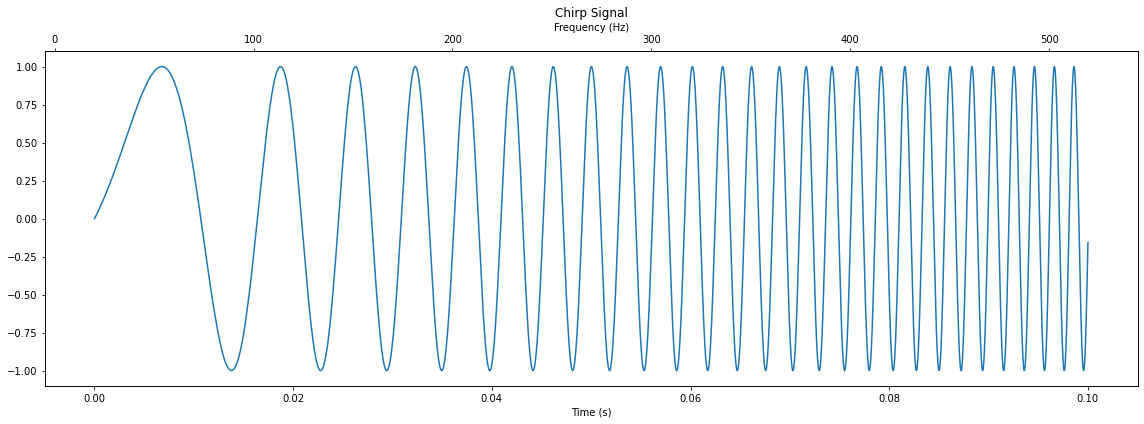

In [7]:
fig = plot_chirp_signal(
    signal=signal, sr=sr, t_cut=0.1, start_freq=start_freq, end_freq=end_freq
)
fig.show()

## Construct AFESim

There are two methods to construct an `AFESimExternal` object. The first one is to use the default constructor. When we use the default constructor, we have all low-level hardware parameters. The second method is to use the `.from_specification()` method. `.from_specification()` provides us with a more human comprehensible way to construct an `AFESimExternal` objects, but it might not always be possible to select the exact parameters we want due to hardware constraints. It'll check and complain if there is any hardware constraint violation, and suggest the closest possible parameters.

Let's first use the default constructor, and then the `.from_specification()` method.

In [8]:
# - Utilize divisive normalization
afesim_dn = AFESimExternal(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    dn_rate_scale_bitshift=(6, 0),
    dn_low_pass_bitshift=12,
    dn_EPS=1,
    fixed_threshold_vec=None,
    down_sampling_factor=50,
)

# - Utilize IAF neurons
afesim_th = AFESimExternal(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="threshold",
    dn_rate_scale_bitshift=None,
    dn_low_pass_bitshift=None,
    dn_EPS=None,
    fixed_threshold_vec=2**27,
    down_sampling_factor=50,
)

Here we have two options for the spike generation mode:

* `divisive_norm`
* `threshold`

When we select `"divisive_norm"`, the divisive normalization block is used for spike generation. When we select `"threshold"`, the IAF spike generation block is used for spike generation.

In the case of `"divisive_norm"`, we have three parameters to control:

* `"dn_rate_scale_bitshift"`
* `"dn_low_pass_bitshift"`
* `"dn_EPS"`

`"fixed_threshold_vec"` is the parameter to control in the case of `"threshold"`. The `"fixed_threshold_vec"` is ignored in the case of `"divisive_norm"`, and the three parameters above are ignored in the case of `"threshold"`.


Let's check the docstring to see what these parameters are actually doing.

In [9]:
help(AFESimExternal.__init__)

Help on function __init__ in module rockpool.devices.xylo.syns65302.afe_sim:

__init__(self, **kwargs)
    Args:
        select_filters (Optional[Tuple[int]], optional): The indices of the filters to be used in the filter bank. Defaults to None: use all filters.
            i.e. select_filters = (0,2,4,8,15) will use Filter 0, Filter 2, Filter 4, Filter 8, and Filter 15.
    
        spike_gen_mode (str, optional): The spike generation mode of the AFE. There are two ways to generate spikes, "divisive_norm" and "threshold". Defaults to "divisive_norm".
            When "divisive_norm" is selected, adaptive thresholds apply, and `dn_rate_scale_bitshift`, `dn_low_pass_bitshift`, `dn_EPS` parameters are used.
            When "threshold" is selected, fixed thresholds apply, and `fixed_threshold_vec` parameter is used.
            For detailed information, please check `DivisiveNormalization` module
    
        dn_rate_scale_bitshift (Optional[Tuple[int]], optional): Used only when `spike_

Now let's check the `from_specification()`. The similar `"divisive_norm"` vs. `"threshold"` distinction applies here as well. The difference is that we have more human comprehensible parameters to control.

In case of `"divisive_norm"`, we have:
* `"rate_scale_factor"` instead of `"dn_rate_scale_bitshift"`
* `"low_pass_averaging_window"` instead of `"dn_low_pass_bitshift"`

When we try to set the `"rate_scale_factor"`, it will automatically calculate the closest possible `"dn_rate_scale_bitshift"` value. The same applies to `"low_pass_averaging_window"` and `"dn_low_pass_bitshift"`.

Additionally, we have `"dt"` which corresponds to `"down_sampling_factor"`.

The rest of the parameters are the same as the default constructor. Let's print the docstring and see the connection between the parameters.


In [10]:
help(AFESimExternal.from_specification)

Help on method from_specification in module rockpool.devices.xylo.syns65302.afe_sim:

from_specification(select_filters: 'Optional[Tuple[int]]' = None, spike_gen_mode: 'str' = 'divisive_norm', rate_scale_factor: 'Optional[int]' = 63, low_pass_averaging_window: 'Optional[float]' = 0.084, dn_EPS: 'Optional[Union[int, Tuple[int]]]' = 1, fixed_threshold_vec: 'Optional[Union[int, Tuple[int]]]' = None, dt: 'Optional[float]' = 0.001024) -> '__AFESimCommon' method of rockpool.nn.modules.module.PostInitMetaMixin instance
    Create an instance of AFESim by specifying higher level parameters for AFESim.
    
    Args:
        audio_sampling_rate (float): Check :py:class:`.AFESim.
        select_filters (Optional[Tuple[int]], optional): Check :py:class:`.AFESim`. Defaults to None.
        spike_gen_mode (str, optional): Check :py:class:`.AFESim`. Defaults to "divisive_norm".
        input_mode (str, optional): Check :py:class:`.AFESim`. Defaults to "external".
        rate_scale_factor (Optional[

Here we can see that, `rate_scale_factor`, `low_pass_averaging_window`, and `dt` does not have a direct representation in hardware. The values we provide are used as a reference and module does a parameter search to find and suggest the closest value. For example if we want the dt=1-e3, the module raises and error and suggest the closest possible value to that. It's the same for `rate_scale_factor`, and `low_pass_averaging_window`, too.

In [11]:
try:
    AFESimExternal.from_specification(dt=1e-3)
except Exception as e:
    print(e)

Closest we can get to `dt` = 0.001000 is 0.001004 with `down_sampling_factor` = 49, diff = 0.000004


In [12]:
afesim = AFESimExternal.from_specification(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    rate_scale_factor=63,
    low_pass_averaging_window=84e-3,
    dn_EPS=1,
    fixed_threshold_vec=None,
    dt=1024e-6,
)

We constructed the `AFESimExternal` object from the specification, utilizing the divisive normalization block. Please feel free to play with the parameters and see how the output changes.

In [13]:
print("AFESim : ", afesim)
print("dt : ", afesim.dt)
print("low_pass_averaging_window : ", afesim.low_pass_averaging_window)
print("rate_scale_factor : ", afesim.rate_scale_factor)

AFESim :  AFESimExternal  with shape (1, 16) {
    ExternalSignal '0_ExternalSignal' with shape (1, 1) {
        ResampleAudio '0_ResampleAudio' with shape (1, 1)
        AudioQuantizer '1_AudioQuantizer' with shape (1, 1)
    }
    ChipButterworth '1_ChipButterworth' with shape (1, 16)
    DivisiveNormalization '2_DivisiveNormalization' with shape (16, 16)
    Raster '3_Raster' with shape (16, 16)
}
dt :  0.001024
low_pass_averaging_window :  0.08388608
rate_scale_factor :  63


## Run the simulation

We need to run the simulation to get the output. The output of the `AFESim` is a 16-channel 4-bit raster. However, there are also intermediate outputs which we can access. Below, we'll go through the outputs one by one.

First, let's run the simulation and get the output and the dictionaries.

In [14]:
out_external, state_external, rec_external = afesim((signal, sr))

In [15]:
out_external.shape

(3907, 16)

Lets print the record dictionary and see what we have.

In [16]:
print(rec_external.keys())

dict_keys(['0_ExternalSignal', '0_ExternalSignal_output', '1_ChipButterworth', '1_ChipButterworth_output', '2_DivisiveNormalization', '2_DivisiveNormalization_output', '3_Raster', '3_Raster_output'])


## Filter Bank output

The first stage is the filterbank, and we can fetch the output with key `"1_ChipButterworth_output"`. The filterbank output is a 16-channel (max) 14-bit integer signal, which is the input to the divisive normalization block.

In the case we select a sub-set of channels through `"select_filters"`, the filterbank output will have exactly the selected number of channels.
Let's plot and observe the filtering effect!

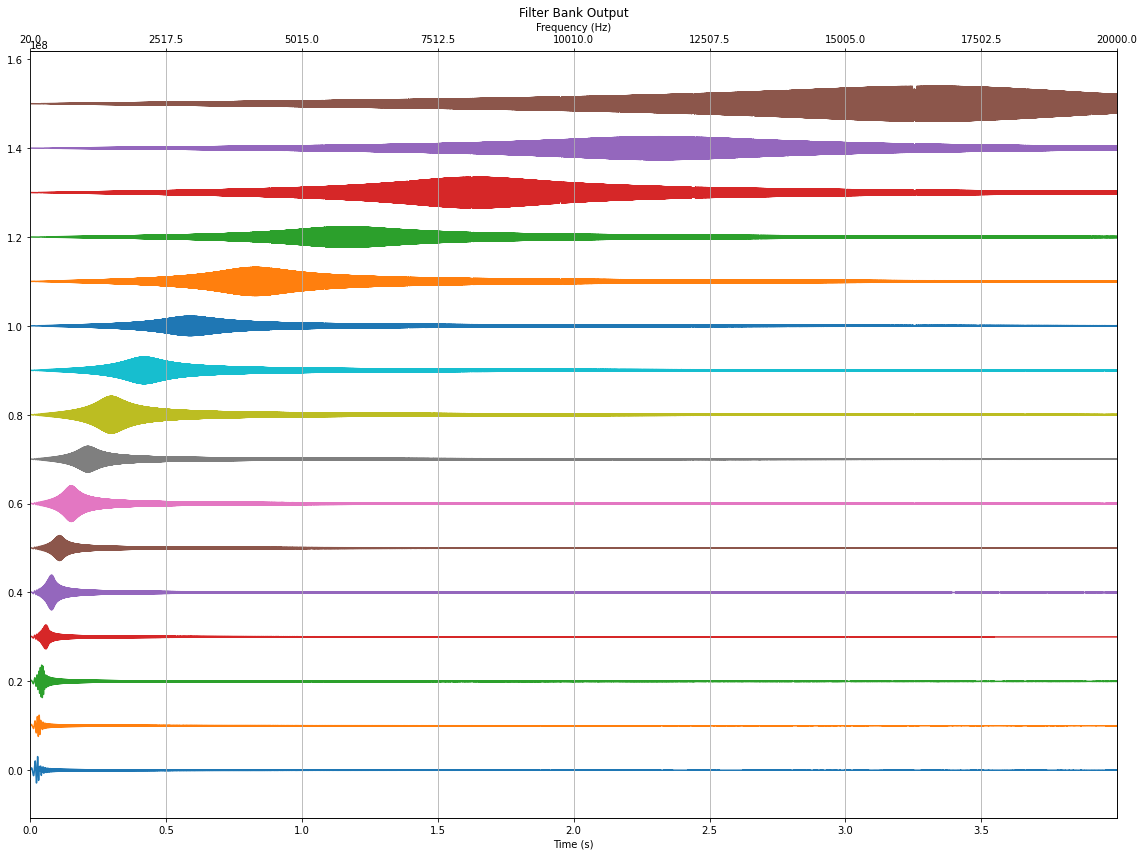

In [17]:
fig = plot_filter_bank_output(
    rec_external["1_ChipButterworth_output"],
    afesim.audio_sampling_rate,
    start_freq=start_freq,
    end_freq=end_freq,
)
fig.show()

As we can see, different filter channels apply different band-pass filters to the input signal. The lower index channels pass lower band frequencies, and the higher index channels higher band frequencies.

## Spike Encoding

The second stage is the spike generation, and we can fetch the output with key `"2_DivisiveNormalization_output"`. The divisive normalization output is 16-channel (max) **1-bit** spike train.

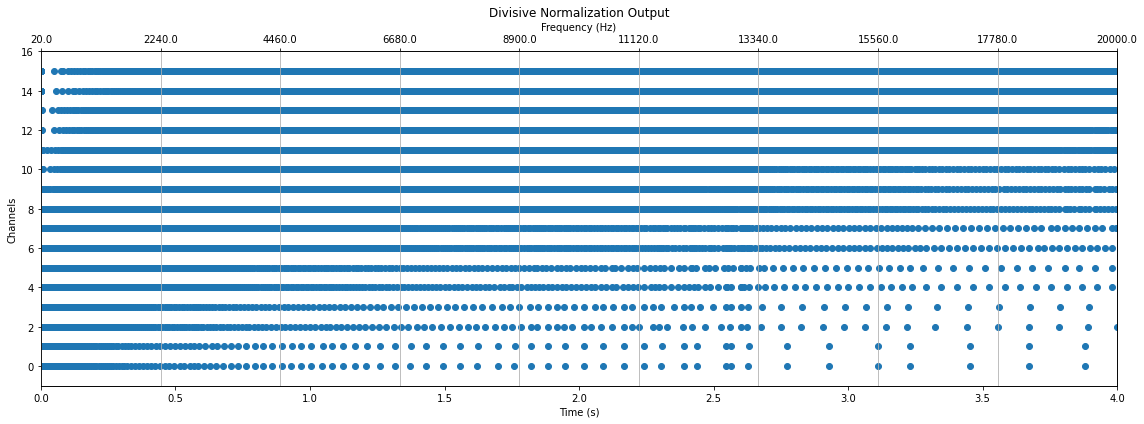

In [18]:
fig = plot_divisive_normalization_output(
    rec_external["2_DivisiveNormalization_output"],
    afesim.audio_sampling_rate,
    start_freq=start_freq,
    end_freq=end_freq,
)
fig.show()

Here the the figure shows the 1-bit 16 channel spike train obtained at the output of the divisive normalization block. We can see that the spikes are densely distributed in the high power regions of the signal.

## Accumulated spikes

Even though the spike encoding obtained at the output of the divisive normalization block is sufficient for the SNN core, we can also accumulate the spikes in a 16-channel 4-bit raster. This provides us with a lower SNN clock rate, and better power efficiency. For that reason, we have the rastering block. Rastering block accumulates spikes given the `"down_sampling_factor"` set at the construction of the `AFESim` object. `"down_sampling_factor"` = 50 means that the rastering block accumulates 50 timesteps of spikes into a single timestep. This means that the SNN core will run at 50 times lower clock rate compared to the AFE block.

Let's check shapes of the outputs, and compare the dt of the AFE block and the SNN core.

In [19]:
__intermediate_shape = rec_external["2_DivisiveNormalization_output"].shape
print(f"Divisive Normalization output shape: {__intermediate_shape}")
print(f"Down Sampling Factor: {afesim.down_sampling_factor}")
print(
    f"{__intermediate_shape[0]} / {afesim.down_sampling_factor} = {__intermediate_shape[0] / afesim.down_sampling_factor}"
)
print(f"\nAFESim output shape: {out_external.shape}")

__snn_freq = afesim.audio_sampling_rate / afesim.down_sampling_factor
print(f"SNN core operating frequency: {__snn_freq} Hz")
print(f"dt = 1/{__snn_freq}s = {1/__snn_freq}")
print(f"Remember dt = {afesim.dt}s")

# - For future reference
if afesim.dt == 1 / __snn_freq:
    print("\nEverything looks good!")
else:
    raise ValueError("Something is wrong!")

Divisive Normalization output shape: (195313, 16)
Down Sampling Factor: 50
195313 / 50 = 3906.26

AFESim output shape: (3907, 16)
SNN core operating frequency: 976.5625 Hz
dt = 1/976.5625s = 0.001024
Remember dt = 0.001024s

Everything looks good!


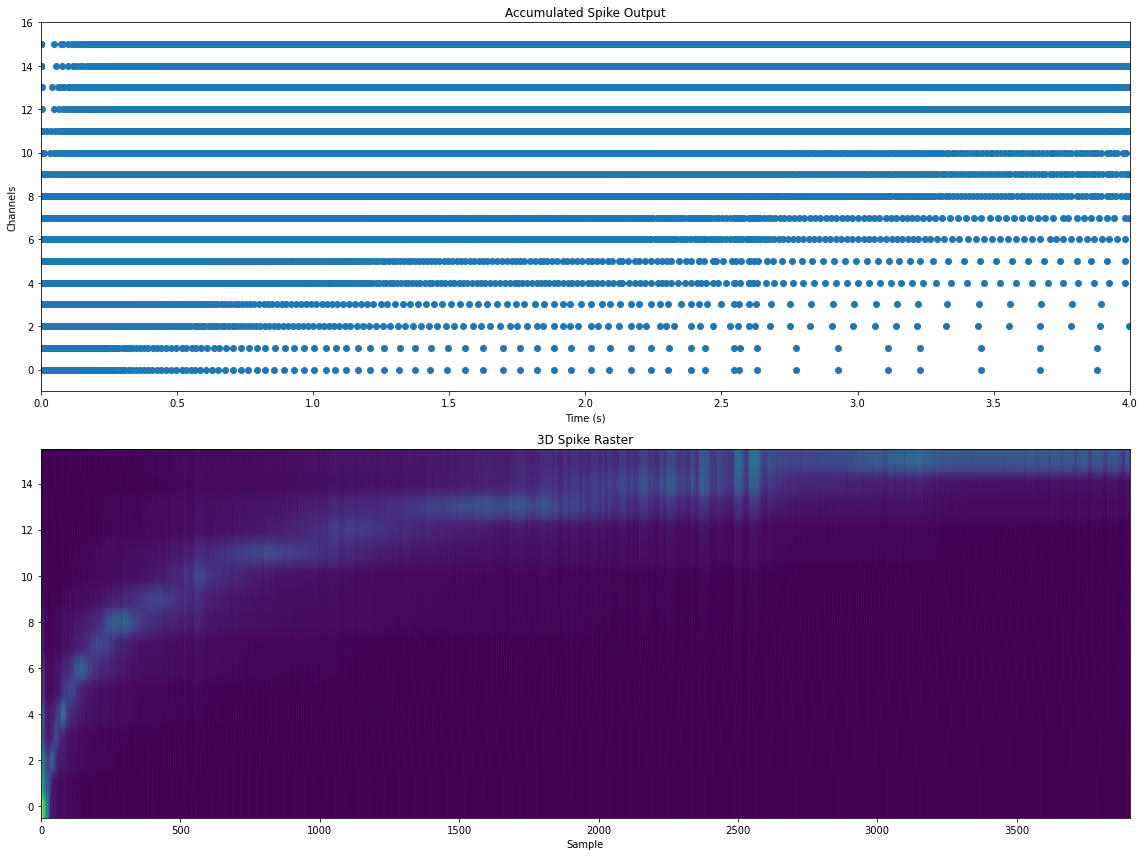

In [20]:
fig = plot_raster_output(out_external, dt=afesim.dt)
fig.show()

Due to that down-sampling, and accumulation into a 4-bit spike representation, now the spike raster plot is not self-sufficient to visualize the output. The second figure encodes the number of spikes in one timestep into the color of the pixel. The greener the pixel, the more spikes are accumulated in that timestep.

Now you're ready to use `AFESim` in your own projects. Please feel free to play with the parameters and see how the output changes!

* For analog microphone, please check the [AFESim with Analog Microphone](afesim_agc.html) tutorial.
* For PDM microphone, please check the [AFESim with PDM Microphone](afesim_pdm.html) tutorial.